Generating data

In [1]:
import sys
sys.path.append('/scratch/phuongpm/bertviz')
from transformers import AlbertTokenizer, AlbertModel 
import pickle
import torch
from transformers.data.processors.squad import SquadResult, SquadV2Processor
from transformers import (
    squad_convert_examples_to_features
)
import numpy as np

In [2]:
from tqdm.notebook import tqdm

In [3]:
np.random.seed(0)

model_version = '/crimea/phuongpm/tuned/squadv2_albert_what'
do_lower_case = True
model = AlbertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = AlbertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)

processor = SquadV2Processor()

print("Generating example ...")
examples = processor.get_dev_examples('/data/medg/misc/phuongpm/clicr_squad_v2_mask/', filename = 'dev1.0.json')

  0%|          | 0/584 [00:00<?, ?it/s]

Generating example ...


100%|██████████| 584/584 [00:26<00:00, 22.22it/s]


In [4]:
random_exps = np.random.choice(examples, 100, replace=False)

print("Generating features ...")
features, dataset = squad_convert_examples_to_features(
    examples=random_exps,
    tokenizer=tokenizer,
    max_seq_length=384,
    doc_stride=128,
    max_query_length=64,
    is_training=False,
    return_dataset='pt',
    threads=1
)

Generating features ...


add example index and unique id: 100%|██████████| 75/75 [00:00<00:00, 49144.32it/s]


In [5]:
alldata = []
print("Generating attention map ... ")
for f in tqdm(features):
    input_ids = torch.tensor([f.input_ids])
    token_type_ids = torch.tensor([f.token_type_ids])
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())
    attention = model(input_ids, token_type_ids=token_type_ids)[-1]
    #generate a [n_layer, n_head, n_tokens, n_tokens] attention map
    attns = np.array([attention[l][0, :, :, :].tolist() for l in range(12)])
    alldata.append({"tokens": tokens, "attns": attns})

Generating attention map ... 


In [26]:
def data_iterator():
    for doc in tqdm(alldata):
        yield doc["tokens"], np.array(doc["attns"])

In [7]:
n_docs = len(alldata)
avg_attns = {
    k: np.zeros((12, 12)) for k in [
      "self", "right", "left", "sep", "sep1", "sep2", "sep_sep", "rest_sep",
      "cls", "punct", "mask", "questionmark"]
}
incomplete_question = 0
for tokens, attns in data_iterator():
    n_tokens = attns.shape[-1]
    # create masks indicating where particular tokens are
    seps, clss, puncts, masks, sep1s, sep2s, questionmarks = (np.zeros(n_tokens) for _ in range(7))
#     foundsep = False
    for position, token in enumerate(tokens):
#         if token == "[SEP]":
#             seps[position] = 1
#             if not foundsep:
#                 sep1s[position] = 1
#                 foundsep = True # found the first sep
#             else:
#                 sep2s[position] = 1
#                 foundsep = False # found the second sep
        if token == "[CLS]":
            clss[position] = 1
        if token == "." or token == "," or token == '?':
            puncts[position] = 1
        if token == '?':
            questionmarks[position] = 1
#         if token == "[MASK]":
#             masks[position] = 1
            
    #fill in [SEP] index
    sep1_index = tokens.index('[SEP]')
    sep2_index = tokens.index('[SEP]', sep1_index + 1)
    seps[sep1_index] = 1
    seps[sep2_index] = 1
    sep1s[sep1_index] = 1
    sep2s[sep2_index] = 1
    #fill in [MASK] index
    try:
        mask_index = tokens.index('[MASK]')
        masks[mask_index] = 1
    except:
        incomplete_question += 1
    


    # create masks indicating which positions are relevant for each key
    sep_seps = np.ones((n_tokens, n_tokens))
    sep_seps *= seps[np.newaxis]
    sep_seps *= seps[:, np.newaxis]

    rest_seps = np.ones((n_tokens, n_tokens))
    rest_seps *= (np.ones(n_tokens) - seps)[:, np.newaxis]
    rest_seps *= seps[np.newaxis]

    selectors = {
      "self": np.eye(n_tokens, n_tokens),
      "right": np.eye(n_tokens, n_tokens, 1),
      "left": np.eye(n_tokens, n_tokens, -1),
      "sep": np.tile(seps[np.newaxis], [n_tokens, 1]),
      "sep1": np.tile(sep1s[np.newaxis], [n_tokens, 1]),
      "sep2": np.tile(sep2s[np.newaxis], [n_tokens, 1]),
      "sep_sep": sep_seps,
      "rest_sep": rest_seps,
      "cls": np.tile(clss[np.newaxis], [n_tokens, 1]),
      "punct": np.tile(puncts[np.newaxis], [n_tokens, 1]),
      "mask": np.tile(masks[np.newaxis], [n_tokens, 1]),
      "questionmark": np.tile(questionmarks[np.newaxis], [n_tokens, 1]),
    }
    # get the average attention for each token type
    for key, selector in selectors.items():
        if key == "sep_sep":
            denom = 2 * n_docs
        elif key == "rest_sep":
            denom = (n_tokens - 2)*n_docs
        elif key == 'mask':
            denom = n_tokens*(n_docs - incomplete_question)
        else:
            denom = n_tokens * n_docs
        avg_attns[key] += (
            (attns * selector[np.newaxis, np.newaxis]).sum(-1).sum(-1) /
            (denom))

In [8]:
#Plotting
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

In [9]:
# Pretty colors
BLACK = "k"
GREEN = "#59d98e"
DARKGREEN = "green"
SEA = "#159d82"
BLUE = "#3498db"
PURPLE = "#9b59b6"
GREY = "#95a5a6"
RED = "#e74c3c"
ORANGE = "#f39c12"

def get_data_points(head_data):
    xs, ys, avgs = [], [], []
    for layer in range(12):
        for head in range(12):
            ys.append(head_data[layer, head])
            xs.append(1 + layer)
        avgs.append(head_data[layer].mean())
    return xs, ys, avgs

In [10]:
def add_line(key, ax, color, label, plot_avgs=True):
    xs, ys, avgs = get_data_points(avg_attns[key])
    ax.scatter(xs, ys, s=12, label=label, color=color)
    if plot_avgs:
        ax.plot(1 + np.arange(len(avgs)), avgs, color=color)
    ax.legend(loc="best")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Avg. Attention")

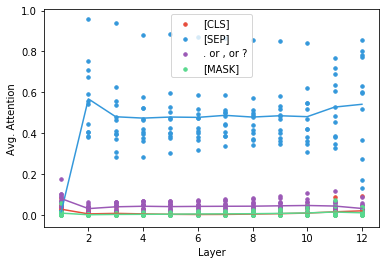

In [11]:
ax = plt.subplot(1, 1, 1)
for key, color, label in [
    ("cls", RED, "[CLS]"),
    ("sep", BLUE, "[SEP]"),
    ("punct", PURPLE, ". or , or ?"),
    ("mask", GREEN, "[MASK]")
]:
    add_line(key, ax, color, label)
    
plt.show()

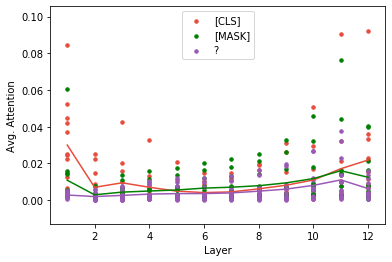

In [12]:
ax = plt.subplot(1, 1, 1)
for key, color, label in [
    ("cls", RED, "[CLS]"),
    ("mask", DARKGREEN, "[MASK]"),
    ("questionmark", PURPLE, "?"),
]:
    add_line(key, ax, color, label)
    
plt.show()

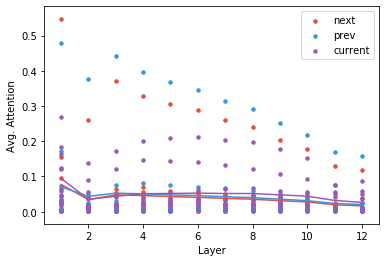

In [13]:
ax = plt.subplot(1, 1, 1)
for key, color, label in [
    ("left", RED, "next"),
    ("right", BLUE, "prev"),
    ("self", PURPLE, "current"),
]:
    add_line(key, ax, color, label, plot_avgs=True)

plt.show()

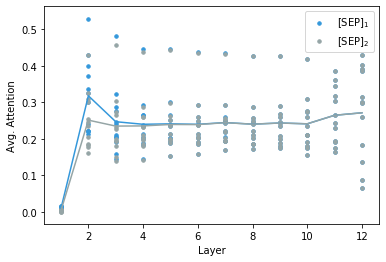

In [14]:
ax = plt.subplot(1, 1, 1)
for key, color, label in [
    ("sep1", BLUE, r"[SEP]$_1$"),
    ("sep2", GREY, r"[SEP]$_2$"),
]:
    add_line(key, ax, color, label)

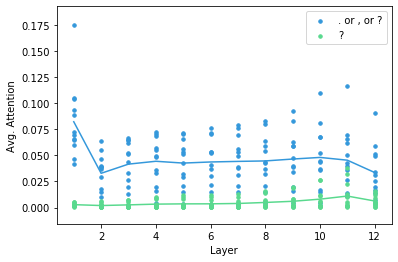

In [15]:
ax = plt.subplot(1, 1, 1)
for key, color, label in [
    ("punct", BLUE, ". or , or ?"),
    ("questionmark", GREEN, "?"),
    
]:
    add_line(key, ax, color, label)

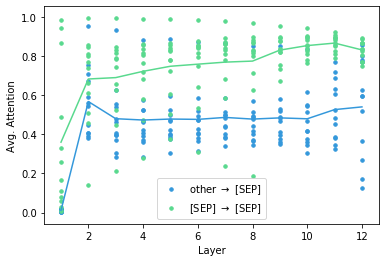

In [16]:
ax = plt.subplot(1, 1, 1)
for key, color, label in [
    ("rest_sep", BLUE, r"other $\rightarrow$ [SEP]"),
    ("sep_sep", GREEN, r"[SEP] $\rightarrow$ [SEP]"),
    
]:
    add_line(key, ax, color, label)

In [17]:
def plotheatmap(key):
    sns.heatmap(avg_attns[key], xticklabels=list(range(1,13)), yticklabels=list(range(1,13)))
    plt.ylim(len(avg_attns[key])+0.5, -0.5)
    plt.ylabel('Layer')
    plt.xlabel('Head')

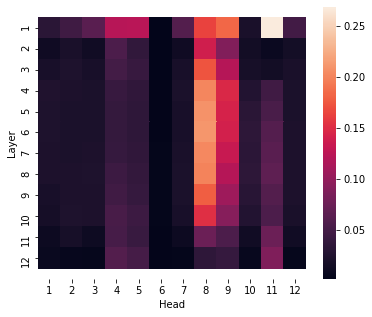

In [18]:
plt.figure(figsize=(6, 5))
plotheatmap('self')

Entropy

In [19]:
uniform_attn_entropy = 0  # entropy of uniform attention
entropies = np.zeros((12, 12))  # entropy of attention heads
entropies_cls = np.zeros((12, 12))  # entropy of attention from [CLS]

for tokens, attns in data_iterator():
    attns = 0.9999 * attns + (0.0001 / attns.shape[-1])  # smooth to avoid NaNs
    uniform_attn_entropy -= np.log(1.0 / attns.shape[-1])
    entropies -= (attns * np.log(attns)).sum(-1).mean(-1)
    entropies_cls -= (attns * np.log(attns))[:, :, 0].sum(-1)

uniform_attn_entropy /= n_docs
entropies /= n_docs
entropies_cls /= n_docs

In [20]:
entropies_mask = np.zeros((12,12))
entropies_seps = np.zeros((12,12))
entropies_sep1s = np.zeros((12,12))
entropies_sep2s = np.zeros((12,12))

incomplete_question = 0
for tokens, attns in data_iterator():
    attns = 0.9999 * attns + (0.0001 / attns.shape[-1])  # smooth to avoid NaNs
    sep1_index = tokens.index('[SEP]')
    sep2_index = tokens.index('[SEP]', sep1_index + 1)
    precal = (attns * np.log(attns))
    entropies_sep1s -= precal[:, :, sep1_index].sum(-1)
    entropies_sep2s -= precal[:, :, sep2_index].sum(-1)
    entropies_seps -= (precal[:, :, sep1_index].sum(-1) + precal[:, :, sep2_index].sum(-1))/2
    
    try:
        mask_index = tokens.index('[MASK]')
        entropies_mask -= precal[:, :, mask_index].sum(-1)
    except:
        incomplete_question += 1
        continue
        
    
    
entropies_mask /= (n_docs - incomplete_question)
entropies_seps /= n_docs
entropies_sep1s /= n_docs
entropies_sep2s /= n_docs

In [21]:
def plot_entropies(ax, data, avgs, label, c):
    ax.scatter(xs, data, c=c, s=5, label=label)
    ax.plot(1 + np.arange(12), avgs, c=c)
    ax.plot([1, 12], [uniform_attn_entropy, uniform_attn_entropy],
          c="k", linestyle="--")
    ax.text(7, uniform_attn_entropy - 0.45, "uniform attention",
          ha="center")
    ax.legend(loc="lower right")
    ax.set_ylabel("Avg. Attention Entropy (nats)")
    ax.set_xlabel("Layer")

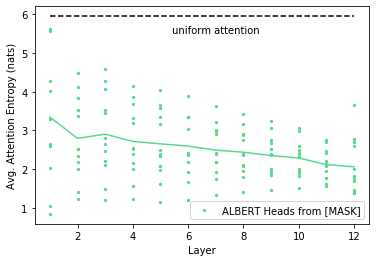

In [22]:
xs, es_mask, avg_es_mask = get_data_points(entropies_mask)
plot_entropies(plt.subplot(1, 1, 1), es_mask, avg_es_mask, "ALBERT Heads from [MASK]",
               c=GREEN)

plt.show()

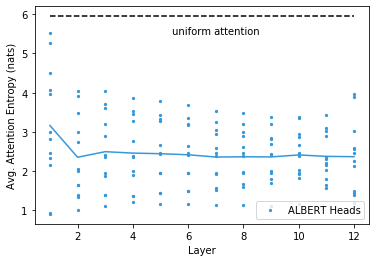

In [23]:
xs, es, avg_es = get_data_points(entropies)
plot_entropies(plt.subplot(1, 1, 1), es, avg_es, "ALBERT Heads",
               c=BLUE)

plt.show()

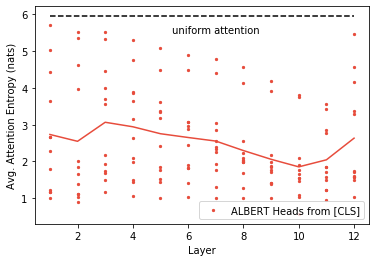

In [24]:
xs, es_cls, avg_es_cls = get_data_points(entropies_cls)
plot_entropies(plt.subplot(1, 1, 1), es_cls, avg_es_cls,
               "ALBERT Heads from [CLS]", c=RED)
plt.show()

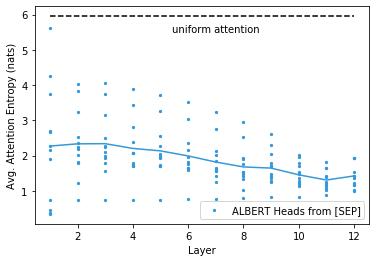

In [25]:
xs, es_sep, avg_es_sep = get_data_points(entropies_seps)
plot_entropies(plt.subplot(1, 1, 1), es_sep, avg_es_sep,
               "ALBERT Heads from [SEP]", c=BLUE)
plt.show()